# Imports

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import Levenshtein
import torchaudio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from wav2vec2decoder import Wav2Vec2Decoder

# Перебор параметров

In [4]:
test_samples = [
    ("./examples/sample1.wav", "IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL READY TO ACKNOWLEDGE MYSELF YOUR DEBTOR FOR AN ACT OF THE MOST NOBLE FORBEARANCE"),
    ("./examples/sample2.wav", "AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKETS OF THEIR OWN IZZY WAS UNDOUBTEDLY THE MAN TO FIND IT OUT AND USE THE INFORMATION WITH A BEAT SUCH AS THAT EVEN GOING HALVES AND WITH ALL THE GRAFT TO THE UPPER BRACKETS HE'D STILL BE ABLE TO MAKE HIS PILE IN A MATTER OF MONTHS"),
    ("./examples/sample3.wav", "GUESS A MAN GETS USED TO ANYTHING HELL MAYBE I CAN HIRE SOME BUMS TO SIT AROUND AND WHOOP IT UP WHEN THE SHIPS COME IN AND BILL THIS AS A REAL OLD MARTIAN DEN OF SIN"),
    ("./examples/sample4.wav", "IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF TIMES SO THERE WAS NO DIFFICULTY IN TURNING OUT A PASSABLE IMITATION OF IT TO THE IMPROVISED STRAINS OF I DIDN'T WANT TO DO IT THE PRISONER STRODE FORTH TO FREEDOM"),
    ("./examples/sample5.wav", "MARGUERITE TIRED OUT WITH THIS LONG CONFESSION THREW HERSELF BACK ON THE SOFA AND TO STIFLE A SLIGHT COUGH PUT UP HER HANDKERCHIEF TO HER LIPS AND FROM THAT TO HER EYES"),
    ("./examples/sample6.wav", "AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ONLY MODE"),
    ("./examples/sample7.wav", "THE INCREASE WAS MAINLY ATTRIBUTABLE TO THE NET INCREASE IN THE AVERAGE SIZE OF OUR FLEETS"),
    ("./examples/sample8.wav", "OPERATING SURPLUS IS A NON CAP FINANCIAL MEASURE WHICH IS DEFINED AS FULLY IN OUR PRESS RELEASE"),
]

In [5]:
lms = [
    "./lm/3-gram.pruned.1e-7.arpa.gz",
    # "./lm/3-gram.arpa.gz",
]
beam_widths = [3, 7, 11]
alphas = [0.5, 1.0, 1.5, 2.0]
betas = [0.5, 1.0, 1.5, 2.0]
d_strategies = ["greedy", "beam", "beam_lm", "beam_lm_rescore"]

grid = list(itertools.product(lms, beam_widths, alphas, betas, d_strategies))
len(grid)

192

In [6]:
results = []
for lm, beam_width, alpha, beta, d_strategy in tqdm(grid):
    decoder = Wav2Vec2Decoder(
        model_name="facebook/wav2vec2-base-960h",
        lm_model_path=lm,
        beam_width=beam_width,
        alpha=alpha,
        beta=beta
    )
    for audio_path, target in test_samples:
        audio_input, sr = torchaudio.load(audio_path)
        transcript = decoder.decode(audio_input, d_strategy)
        cer = Levenshtein.distance(target, transcript.strip()) / len(target)
        wer = Levenshtein.distance(target.split(" "), transcript.strip().split(" ")) / len(target.split(" "))
        
        results.append({
            "audio_path": audio_path,
            "target": target,
            "transcript": transcript,
            "cer": cer,
            "wer": wer,
            "decoding_strategy": d_strategy,
            "lm": lm,
            "beam_width": beam_width,
            "alpha": alpha,
            "beta": beta,
        })

    


  0%|          | 0/192 [00:00<?, ?it/s]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading the LM will be faster if you build a binary file.
Reading /Users/kbduvakin/GenSpeech/assignment_2/lm/3-gram.pruned.1e-7.arpa.gz
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
  1%|          | 1/192 [00:04<13:51,  4.35s/it]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading the LM will 

# Анализ

In [16]:
results = pd.DataFrame(results)

In [17]:
results.sample(5)

,audio_path,target,transcript,cer,wer,decoding_strategy,lm,beam_width,alpha,beta
1360,./examples/sample1.wav,IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUN...,IF YOU AR GNEROUS HE IS FTING OPORTUNITY FOR T...,0.258537,0.605263,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,11,1.5,1.5
1330,./examples/sample3.wav,GUESS A MAN GETS USED TO ANYTHING HELL MAYBE I...,S GTS USE TO AYTHING AYBE I CN HISOMEBUMS TO S...,0.418182,0.864865,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,11,1.5,1.0
1519,./examples/sample8.wav,OPERATING SURPLUS IS A NON CAP FINANCIAL MEASU...,OPERATING CURPLUS IS A NON GAB FINANCIAL MEASU...,0.157895,0.352941,beam,./lm/3-gram.pruned.1e-7.arpa.gz,11,2.0,2.0
40,./examples/sample1.wav,IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUN...,IF YOU ARE GENEROUS HERE IS A FITING OPORTUNIT...,0.048780,0.131579,beam,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,1.0
227,./examples/sample4.wav,IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF T...,IT WAS TE TUNE THEY HAD ALL HEARD HUNDREDS OF ...,0.019231,0.073171,greedy,./lm/3-gram.pruned.1e-7.arpa.gz,3,1.0,2.0


### Лучшие гиперпараметры

In [18]:
import numpy as np

mean_results = (
    results
    .groupby(['lm', 'beam_width', 'alpha', 'beta', 'decoding_strategy'])
    .agg({'wer': np.mean, 'cer': np.mean})
    .reset_index()
    .sort_values('wer', ascending=True)
)
mean_results

,lm,beam_width,alpha,beta,decoding_strategy,wer,cer
95,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,2.0,greedy,0.197297,0.084907
107,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.5,1.5,greedy,0.197297,0.084907
103,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.5,1.0,greedy,0.197297,0.084907
99,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.5,0.5,greedy,0.197297,0.084907
91,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,1.5,greedy,0.197297,0.084907
...,...,...,...,...,...,...,...
117,./lm/3-gram.pruned.1e-7.arpa.gz,7,2.0,1.0,beam_lm,0.947492,0.701862
181,./lm/3-gram.pruned.1e-7.arpa.gz,11,2.0,1.0,beam_lm,0.947492,0.700124
177,./lm/3-gram.pruned.1e-7.arpa.gz,11,2.0,0.5,beam_lm,0.951548,0.729846
49,./lm/3-gram.pruned.1e-7.arpa.gz,3,2.0,0.5,beam_lm,0.951548,0.745650


### Лучшие гиперпараметры для каждого способа декодировать

In [19]:
best_params = (
    mean_results.loc[
        mean_results.groupby('decoding_strategy')['wer'].idxmin()
    ]
)
best_params

,lm,beam_width,alpha,beta,decoding_strategy,wer,cer
104,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.5,1.5,beam,0.270985,0.100943
13,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0,beam_lm,0.285535,0.108392
126,./lm/3-gram.pruned.1e-7.arpa.gz,7,2.0,2.0,beam_lm_rescore,0.270985,0.100943
95,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,2.0,greedy,0.197297,0.084907


In [20]:
best_results = results.merge(best_params.drop(columns=['wer', 'cer']), on=['decoding_strategy', 'lm', 'beam_width', 'alpha', 'beta'], how='inner')
best_results

,audio_path,target,transcript,cer,wer,decoding_strategy,lm,beam_width,alpha,beta
0,./examples/sample1.wav,IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUN...,IF YOU ARE GENEROUS HERE IS A FITING OPORTUNIT...,0.053659,0.157895,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
1,./examples/sample2.wav,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,0.021818,0.105263,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
2,./examples/sample3.wav,GUESS A MAN GETS USED TO ANYTHING HELL MAYBE I...,GUES A MAN GETS USED TO ANYTHING HEL MAYBE I C...,0.030303,0.135135,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
3,./examples/sample4.wav,IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF T...,IT WAS A TUNE THEY HAD AL HEARD HUNDREDS OF TI...,0.024038,0.121951,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
4,./examples/sample5.wav,MARGUERITE TIRED OUT WITH THIS LONG CONFESSION...,MARGUERITE TIRED OUT WITH HIS LONG CONFESION T...,0.011905,0.062500,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
5,./examples/sample6.wav,AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ...,OF THE TIME AL PARTICIPANS A NLISAN ONLY MO,0.290909,0.727273,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
6,./examples/sample7.wav,THE INCREASE WAS MAINLY ATTRIBUTABLE TO THE NE...,TGREACE WAS MAINLY ATRIBUTABLE TO INCREASIDNG ...,0.255556,0.562500,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
7,./examples/sample8.wav,OPERATING SURPLUS IS A NON CAP FINANCIAL MEASU...,OPERATING CURPLUS IS A NON GA FINANCIAL MEASUR...,0.178947,0.411765,beam_lm,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0
8,./examples/sample1.wav,IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUN...,IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUN...,0.039024,0.078947,greedy,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,2.0
9,./examples/sample2.wav,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,0.000000,0.000000,greedy,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,2.0


### CER по тестовым сэмплам в разрезе способов декодинга

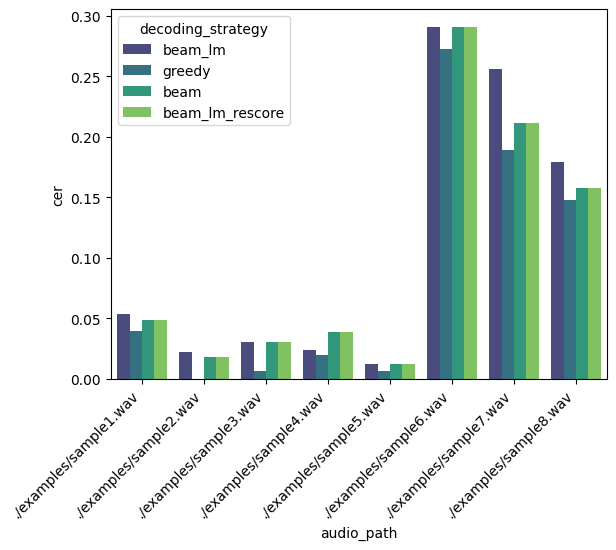

In [21]:
sns.barplot(x="audio_path", y="cer", hue="decoding_strategy", data=best_results, palette="viridis")
tmp = plt.xticks(rotation=45, ha='right')

### WER по тестовым сэмплам в разрезе способов декодинга

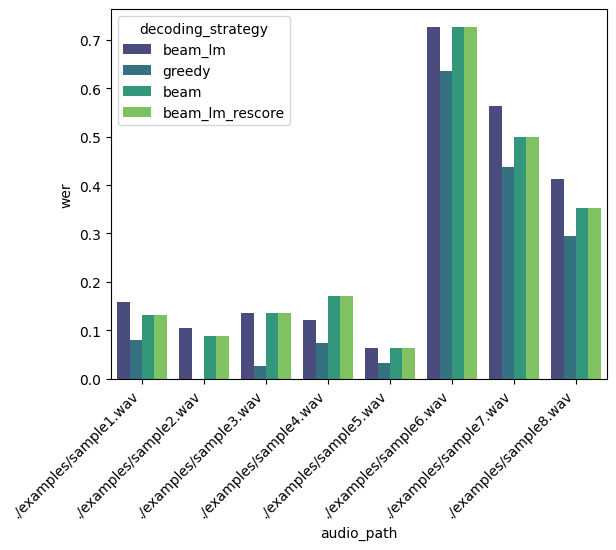

In [22]:
sns.barplot(x="audio_path", y="wer", hue="decoding_strategy", data=best_results, palette="viridis")
tmp = plt.xticks(rotation=45, ha='right')

### Распределение CER в разрезе способов декодинга

<Axes: xlabel='decoding_strategy', ylabel='cer'>

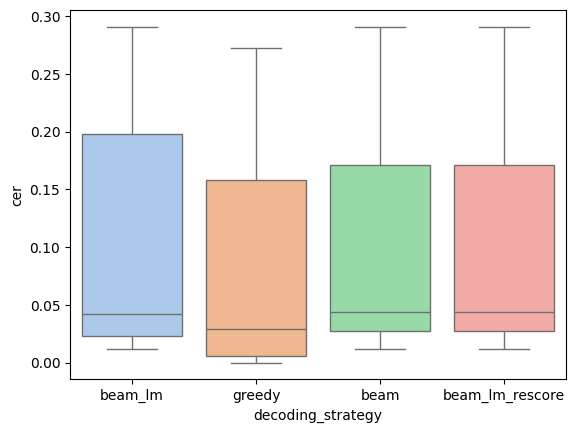

In [23]:
sns.boxplot(x="decoding_strategy", hue="decoding_strategy", y="cer", data=best_results, palette="pastel")

### Распределение WER в разрезе способов декодинга

<Axes: xlabel='decoding_strategy', ylabel='wer'>

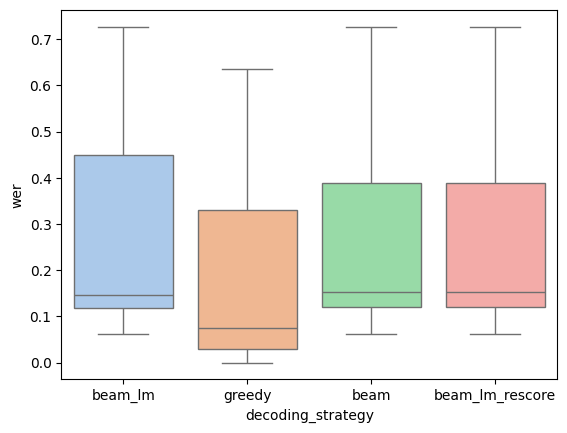

In [24]:
sns.boxplot(x="decoding_strategy", hue="decoding_strategy", y="wer", data=best_results, palette="pastel")

# Larger LM

In [25]:
best_params

,lm,beam_width,alpha,beta,decoding_strategy,wer,cer
104,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.5,1.5,beam,0.270985,0.100943
13,./lm/3-gram.pruned.1e-7.arpa.gz,3,0.5,2.0,beam_lm,0.285535,0.108392
126,./lm/3-gram.pruned.1e-7.arpa.gz,7,2.0,2.0,beam_lm_rescore,0.270985,0.100943
95,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,2.0,greedy,0.197297,0.084907


In [28]:
best_params_list = best_params[["beam_width", "alpha", "beta", "decoding_strategy"]].to_dict(orient="records")
best_params_list

[{'beam_width': 7, 'alpha': 1.5, 'beta': 1.5, 'decoding_strategy': 'beam'},
 {'beam_width': 3, 'alpha': 0.5, 'beta': 2.0, 'decoding_strategy': 'beam_lm'},
 {'beam_width': 7,
  'alpha': 2.0,
  'beta': 2.0,
  'decoding_strategy': 'beam_lm_rescore'},
 {'beam_width': 7, 'alpha': 1.0, 'beta': 2.0, 'decoding_strategy': 'greedy'}]

In [31]:
larger_lm = "./lm/3-gram.arpa.gz"

grid = [(larger_lm, v["beam_width"], v["alpha"], v["beta"], v["decoding_strategy"]) for v in best_params_list]
grid

[('./lm/3-gram.arpa.gz', 7, 1.5, 1.5, 'beam'),
 ('./lm/3-gram.arpa.gz', 3, 0.5, 2.0, 'beam_lm'),
 ('./lm/3-gram.arpa.gz', 7, 2.0, 2.0, 'beam_lm_rescore'),
 ('./lm/3-gram.arpa.gz', 7, 1.0, 2.0, 'greedy')]

In [33]:
results_larger_lm = []

for lm, beam_width, alpha, beta, d_strategy in tqdm(grid):
    decoder = Wav2Vec2Decoder(
        model_name="facebook/wav2vec2-base-960h",
        lm_model_path=lm,
        beam_width=beam_width,
        alpha=alpha,
        beta=beta
    )
    for audio_path, target in test_samples:
        audio_input, sr = torchaudio.load(audio_path)
        transcript = decoder.decode(audio_input, d_strategy)
        cer = Levenshtein.distance(target, transcript.strip()) / len(target)
        wer = Levenshtein.distance(target.split(" "), transcript.strip().split(" ")) / len(target.split(" "))
        
        results_larger_lm.append({
            "audio_path": audio_path,
            "target": target,
            "transcript": transcript,
            "cer": cer,
            "wer": wer,
            "decoding_strategy": d_strategy,
            "lm": lm,
            "beam_width": beam_width,
            "alpha": alpha,
            "beta": beta,
        })

  0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading the LM will be faster if you build a binary file.
Reading /Users/kbduvakin/GenSpeech/assignment_2/lm/3-gram.arpa.gz
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
 25%|██▌       | 1/4 [00:29<01:28, 29.61s/it]Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading the LM will be faster if you build a binary file.
Reading /Users/

In [34]:
results_larger_lm = pd.DataFrame(results_larger_lm)

In [35]:
results_larger_lm.sample(5)

,audio_path,target,transcript,cer,wer,decoding_strategy,lm,beam_width,alpha,beta
11,./examples/sample4.wav,IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF T...,IT WAS E TUNE THEY HAD AL HEARD HUNDREDS OF TI...,0.033654,0.170732,beam_lm,./lm/3-gram.arpa.gz,3,0.5,2.0
21,./examples/sample6.wav,AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ...,OF THE TIME AL PARTICIPANTS ANELISAN ONLY MOKED,0.290909,0.727273,beam_lm_rescore,./lm/3-gram.arpa.gz,7,2.0,2.0
5,./examples/sample6.wav,AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ...,OF THE TIME AL PARTICIPANTS ANELISAN ONLY MOTED,0.290909,0.727273,beam,./lm/3-gram.arpa.gz,7,1.5,1.5
22,./examples/sample7.wav,THE INCREASE WAS MAINLY ATTRIBUTABLE TO THE NE...,TEGRECE WAS MAINLY ATRIBUTABLE TO N INCREASING...,0.211111,0.500000,beam_lm_rescore,./lm/3-gram.arpa.gz,7,2.0,2.0
17,./examples/sample2.wav,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,0.018182,0.087719,beam_lm_rescore,./lm/3-gram.arpa.gz,7,2.0,2.0


In [36]:
all_results = pd.concat([best_results, results_larger_lm])
all_results.sample(5)

,audio_path,target,transcript,cer,wer,decoding_strategy,lm,beam_width,alpha,beta
9,./examples/sample2.wav,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,0.021818,0.105263,beam_lm,./lm/3-gram.arpa.gz,3,0.5,2.0
7,./examples/sample8.wav,OPERATING SURPLUS IS A NON CAP FINANCIAL MEASU...,OPERATING CURPLUS IS A NON GAB FINANCIAL MEASU...,0.157895,0.352941,beam,./lm/3-gram.arpa.gz,7,1.5,1.5
0,./examples/sample1.wav,IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUN...,IF YOU ARE GENEROUS HERE IS A FITING OPORTUNIT...,0.048780,0.131579,beam,./lm/3-gram.arpa.gz,7,1.5,1.5
9,./examples/sample2.wav,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKE...,0.000000,0.000000,greedy,./lm/3-gram.pruned.1e-7.arpa.gz,7,1.0,2.0
27,./examples/sample4.wav,IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF T...,IT WAS TE TUNE THEY HAD ALL HEARD HUNDREDS OF ...,0.019231,0.073171,greedy,./lm/3-gram.arpa.gz,7,1.0,2.0


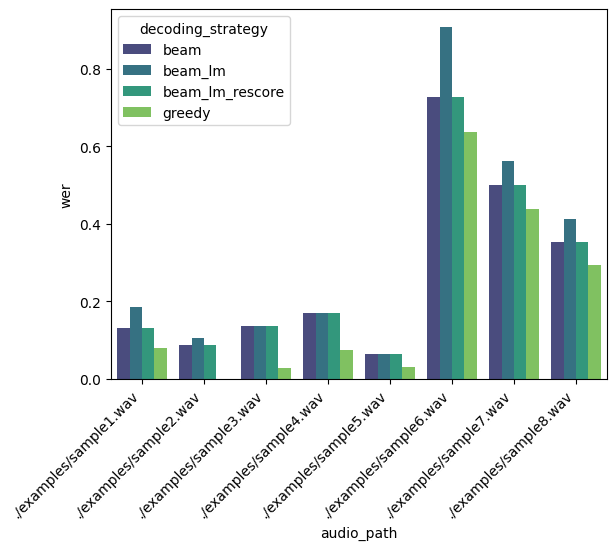

In [38]:
sns.barplot(x="audio_path", y="wer", hue="decoding_strategy", data=all_results[all_results["lm"] == larger_lm], palette="viridis")
tmp = plt.xticks(rotation=45, ha='right')

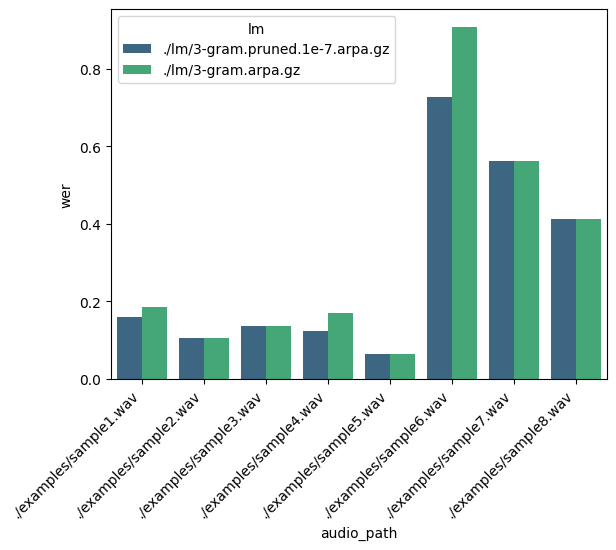

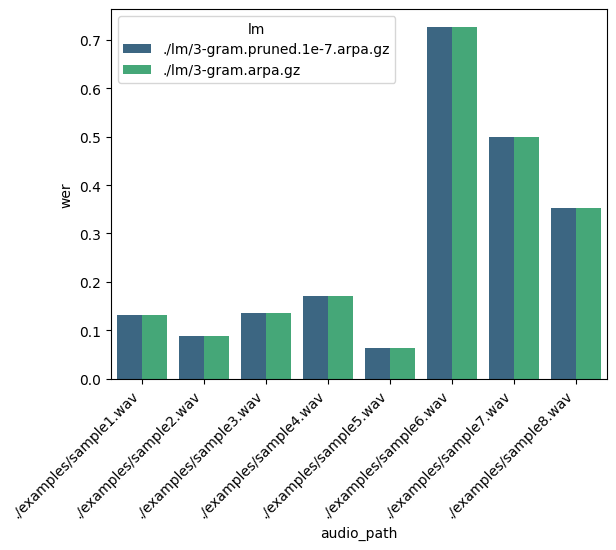

In [39]:
for decoding_strategy in ["beam_lm", "beam_lm_rescore"]:
    sns.barplot(x="audio_path", y="wer", hue="lm", data=all_results[all_results["decoding_strategy"] == decoding_strategy], palette="viridis")
    tmp = plt.xticks(rotation=45, ha='right')
    plt.show()


# Выводы

* Лучше от больше LM не стало в данном случае.
* Лучший способ декодирования получился - greedy.
* Увеличение beam_width положительно сказывается на качестве beam_* методов декодинга.
* Как будто бы, чтобы хорошо подобрать параметры alpha, beta нужна побольше val выборка. 